In [1]:
import sys
sys.path.insert(0, '..')

from Process_gene_data import process_gene_data
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import itertools 
import sys
import json
import matplotlib.cm as cm


Calculate Condition Numbers

In [2]:
# Modified computeC function to prevent dimension mismatch during mixing
def computeC(arrays_gene, readlengh, gene_dict):
    
    def is_subarray(arr, subarr):
        n, m = len(arr), len(subarr)
        arr = list(arr)
        subarr = list(subarr)
        if m > n:
            return False

        for i in range(n - m + 1):
            current_subarr = arr[i:i + m]
            if current_subarr == subarr:
                return True

        return False

    arrays = [array[:] for array in arrays_gene]

    gene_dict_copy = gene_dict.copy()
    length = []
    for array in arrays:
        length_array = sum([gene_dict_copy[key] for key in array])
        length.append(length_array)

    if readlengh > max(length):
        n = len(arrays_gene)
        rows = 2**n - 1
        cols = n
        Cmatrix = np.zeros((rows, cols))
        for i in range(min(rows, cols)):
            Cmatrix[i, i] = 1
        return Cmatrix

    bools = [x > readlengh for x in length]
    max_key = max(gene_dict_copy.keys())

    for i, array in enumerate(arrays):
        if not bools[i]:
            new_key = max_key + 1
            arrays[i] = [new_key]
            gene_dict_copy[new_key] = readlengh + 100
            max_key = new_key

    def generate_combinations_matrix(num_letters):
        letters = [chr(ord('A') + i) for i in range(num_letters)]  # Automatically generate letter list
        n = len(letters)
        combinations = []

        for r1 in range(1, n + 1):
            for combo in itertools.combinations(letters, r1):
                row = [1 if letter in combo else 0 for letter in letters]
                combinations.append(row)
        combinations.sort(key=lambda row: sum(row))

        return combinations

    r = generate_combinations_matrix(len(arrays))
    r = [i for i in r if i.count(1) > 1]

    result_array = []
    for i in r:
        k = 0
        for j in range(0,len(arrays)):
            if i[j] == 1 and k==0 :
                common_result = set(arrays[j])
                k = 1
            elif i[j] == 1 and k==1 :
                common_result &= set(arrays[j])
        result_array.append(list(common_result)) 
    result_array = [sorted(i) for i in result_array]

    result_array_part = []
    for index, row in enumerate(result_array, 1):
        result = []
        location = []
        location_array = []
        if len(row) == 0:
            result = []
        else: 
            current_group = [row[0]]
            k = 0
            for num in row[1:]:
                for i in range (0,len(arrays)):
                    if r[index-1][i] == 1:
                        location.append(arrays[i].index(num))
                        location_array.append(i)
                for j in range(0,len(location_array)):
                    if arrays[location_array[j]][location[j]-1] == row[row.index(num) - 1]:
                        k = k + 1
                if k == len(location_array):
                    current_group.append(num)
                else:
                    result.append(current_group)
                    current_group = [num]
                location_array = []
                location = []
                k = 0
            result.append(current_group)
        result_array_part.append(result)
        
    realans = []
    for i in range(0, len(result_array_part)):
        ans = [sublist for sublist in result_array_part[i] if sum([gene_dict_copy[key] for key in sublist]) >= readlengh]
        realans.append(ans)

    def find_rows_with_one_more(matrix, row):
        reference_row = matrix[row]
        matching_rows = []
        linenumber = []
        columns_of_ones = []

        for row2 in matrix:
            ones_indices = [i for i, value in enumerate(row2) if value == 1]
            columns_of_ones.append(ones_indices)

        for row3, j in enumerate(matrix):
            if np.sum(j) == np.sum(reference_row) + 1 and set(columns_of_ones[row]).issubset(columns_of_ones[row3]):
                linenumber.append(row3)
        return linenumber

    def find_rows_by_indices(matrix, indices):
        selected_rows = [matrix[i] for i in indices]
        return selected_rows
    
    totalsum = []
    for row,overlapping in enumerate(realans):
        overpart = find_rows_by_indices(realans,find_rows_with_one_more(r, row))
        if overpart == [] :
            npublic = 0
            for i in realans[len(realans)-1]:
                npublic = (sum([gene_dict_copy[key] for key in i]) - readlengh + 1) + npublic
            totalsum.append(npublic)
        else:
            sum_result2 = 0
            for i in overlapping:
                iii = i
                includeii = []
                for rowii in overpart:
                    for elementii in rowii:
                        if is_subarray(iii,elementii):
                            includeii.append(elementii)

                includeii = [list(x) for x in set(tuple(x) for x in includeii)]
                includeiinew = []
                for element2 in includeii:
                    suminclude = 0
                    for j in includeii:
                        if is_subarray(j, element2):
                            suminclude = suminclude+1
                    if suminclude==1:
                        includeiinew.append(element2)
                includeiinew = sorted(includeiinew, key=lambda x: x[0])

                if len(includeiinew) == 0:
                    sum_result2 = sum_result2 + sum([gene_dict_copy[key] for key in i]) - readlengh + 1
                else:
                    sum_i = sum([gene_dict_copy[key] for key in i])
                    list_i = [0 for _ in range(sum_i - readlengh +1)]
                    for element_i in includeiinew:
                        first_i = element_i[0]
                        lovation_i = i.index(first_i)
                        sum_ele_i = sum([gene_dict_copy[key] for key in element_i])
                        sum_first = sum([gene_dict_copy[key] for key in i[:lovation_i]]) 
                        list_i[sum_first:sum_ele_i+sum_first-readlengh+1] = [1] * (sum_ele_i-readlengh+1) 
                    count_of_zeros = list_i.count(0)
                    sum_result2 = sum_result2 + count_of_zeros
            totalsum.append(sum_result2)
    
    n = len(arrays)
    rows = 2**n - 1
    cols = n
    Cmatrix = np.zeros((rows, cols))
    for i in range(n, 2**n-1):
        for j in range(0,n):
            if r[i-n][j] == 1:
                Cmatrix[i][j] = totalsum[i-n]/(sum([gene_dict_copy[key] for key in arrays[j]])- readlengh + 1)
    column_sums = np.sum(Cmatrix, axis=0)
    for k in range(0,n):
        Cmatrix[k][k] = 1 - column_sums[k]
        
    return Cmatrix

In [3]:
# Set lengths
short = 150
long = 3000

In [4]:
# 1
filename = '/Users/gyh/Documents/github/TCCN/Gene_Data/example_1.txt'
arrays, gene_dict = process_gene_data(filename)
print(arrays)
print(gene_dict)

[[1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24], [1, 2, 3, 4, 5, 6], [4, 5, 8, 9, 10, 11], [9, 10, 12, 13, 14, 15], [22, 23, 25, 26]]
{1: 919, 2: 184, 3: 179, 4: 176, 5: 106, 6: 945, 7: 82, 8: 91, 9: 107, 10: 90, 11: 81, 12: 157, 13: 107, 14: 103, 15: 85, 16: 135, 17: 96, 18: 138, 19: 117, 20: 166, 21: 386, 22: 180, 23: 79, 24: 216, 25: 216, 26: 95}


In [5]:
# Initialize condition number list
condition_numbers_1 = []
proportions = np.arange(0.0, 1.1, 0.1)

C1 = computeC(arrays, short, gene_dict)
C2 = computeC(arrays, long, gene_dict)

# Calculate condition numbers for different proportions
for p in proportions:
    if p == 0:
        CCT3 = np.dot(C1.T, C1)
    elif p == 1:
        CCT3 = np.dot(C2.T, C2)
    else:
        C3 = np.vstack(((1-p) * C1, p * C2)) 
        CCT3 = np.dot(C3.T, C3)
    condition_number = np.linalg.cond(CCT3)
    condition_numbers_1.append(condition_number)
condition_numbers_1 = [np.log10(x) for x in condition_numbers_1]


In [6]:
# 2
filename = '/Users/gyh/Documents/github/TCCN/Gene_Data/Figure_42.txt'
arrays, gene_dict = process_gene_data(filename)
print(arrays)
print(gene_dict)

[[1, 4, 5, 6, 7, 8, 9, 10, 12, 13], [1, 2, 3], [4, 5, 6, 7, 8, 9, 10, 11], [4, 5, 6, 7, 8, 9, 10, 12, 14]]
{1: 497, 2: 3083, 3: 347, 4: 10168, 5: 269, 6: 180, 7: 803, 8: 61, 9: 2490, 10: 134, 11: 375, 12: 151, 13: 400, 14: 292}


In [7]:
# Initialize condition number list
condition_numbers_2 = []
proportions = np.arange(0.0, 1.1, 0.1)

C1 = computeC(arrays, short, gene_dict)
C2 = computeC(arrays, long, gene_dict)

# Calculate condition numbers for different proportions
for p in proportions:
    if p == 0:
        CCT3 = np.dot(C1.T, C1)
    elif p == 1:
        CCT3 = np.dot(C2.T, C2)
    else:
        C3 = np.vstack(((1-p) * C1, p * C2)) 
        CCT3 = np.dot(C3.T, C3)
    condition_number = np.linalg.cond(CCT3)
    condition_numbers_2.append(condition_number)
condition_numbers_2 = [np.log10(x) for x in condition_numbers_2]


In [8]:
# 3
filename = '/Users/gyh/Documents/github/TCCN/Gene_Data/Figure_43.txt'
arrays, gene_dict = process_gene_data(filename)
print(arrays)
print(gene_dict)

[[2, 3, 4, 6, 9, 10, 11, 13, 14, 15, 16], [1, 9, 10, 11, 12], [2, 3, 4, 5], [2, 3, 4, 6, 8], [2, 3, 4, 6, 7], [2, 3, 6, 9, 10, 11, 13, 14, 15, 16], [13, 15, 17]]
{1: 65, 2: 72, 3: 53, 4: 96, 5: 352, 6: 124, 7: 282, 8: 352, 9: 185, 10: 128, 11: 96, 12: 189, 13: 937, 14: 151, 15: 955, 16: 3156, 17: 351}


In [9]:
# Initialize condition number list
condition_numbers_3 = []
proportions = np.arange(0.0, 1.1, 0.1)

C1 = computeC(arrays, short, gene_dict)
C2 = computeC(arrays, long, gene_dict)

# Calculate condition numbers for different proportions
for p in proportions:
    if p == 0:
        CCT3 = np.dot(C1.T, C1)
    elif p == 1:
        CCT3 = np.dot(C2.T, C2)
    else:
        C3 = np.vstack(((1-p) * C1, p * C2)) 
        CCT3 = np.dot(C3.T, C3)
    condition_number = np.linalg.cond(CCT3)
    condition_numbers_3.append(condition_number)
condition_numbers_3 = [np.log10(x) for x in condition_numbers_3]


In [10]:
# 4
filename = '/Users/gyh/Documents/github/TCCN/Gene_Data/Figure_44.txt'
arrays, gene_dict = process_gene_data(filename)
print(arrays)
print(gene_dict)

[[1, 2, 4, 5, 7, 9, 10, 11, 12], [1, 4, 5, 6], [1, 2, 3], [2, 4, 5, 7, 9, 10, 11, 12], [7, 8]]
{1: 162, 2: 125, 3: 34, 4: 63, 5: 246, 6: 333, 7: 333, 8: 386, 9: 224, 10: 78, 11: 158, 12: 1789}


In [11]:
# Initialize condition number list
condition_numbers_4 = []
proportions = np.arange(0.0, 1.1, 0.1)

C1 = computeC(arrays, short, gene_dict)
C2 = computeC(arrays, long, gene_dict)

# Calculate condition numbers for different proportions
for p in proportions:
    if p == 0:
        CCT3 = np.dot(C1.T, C1)
    elif p == 1:
        CCT3 = np.dot(C2.T, C2)
    else:
        C3 = np.vstack(((1-p) * C1, p * C2)) 
        CCT3 = np.dot(C3.T, C3)
    condition_number = np.linalg.cond(CCT3)
    condition_numbers_4.append(condition_number)
condition_numbers_4 = [np.log10(x) for x in condition_numbers_4]

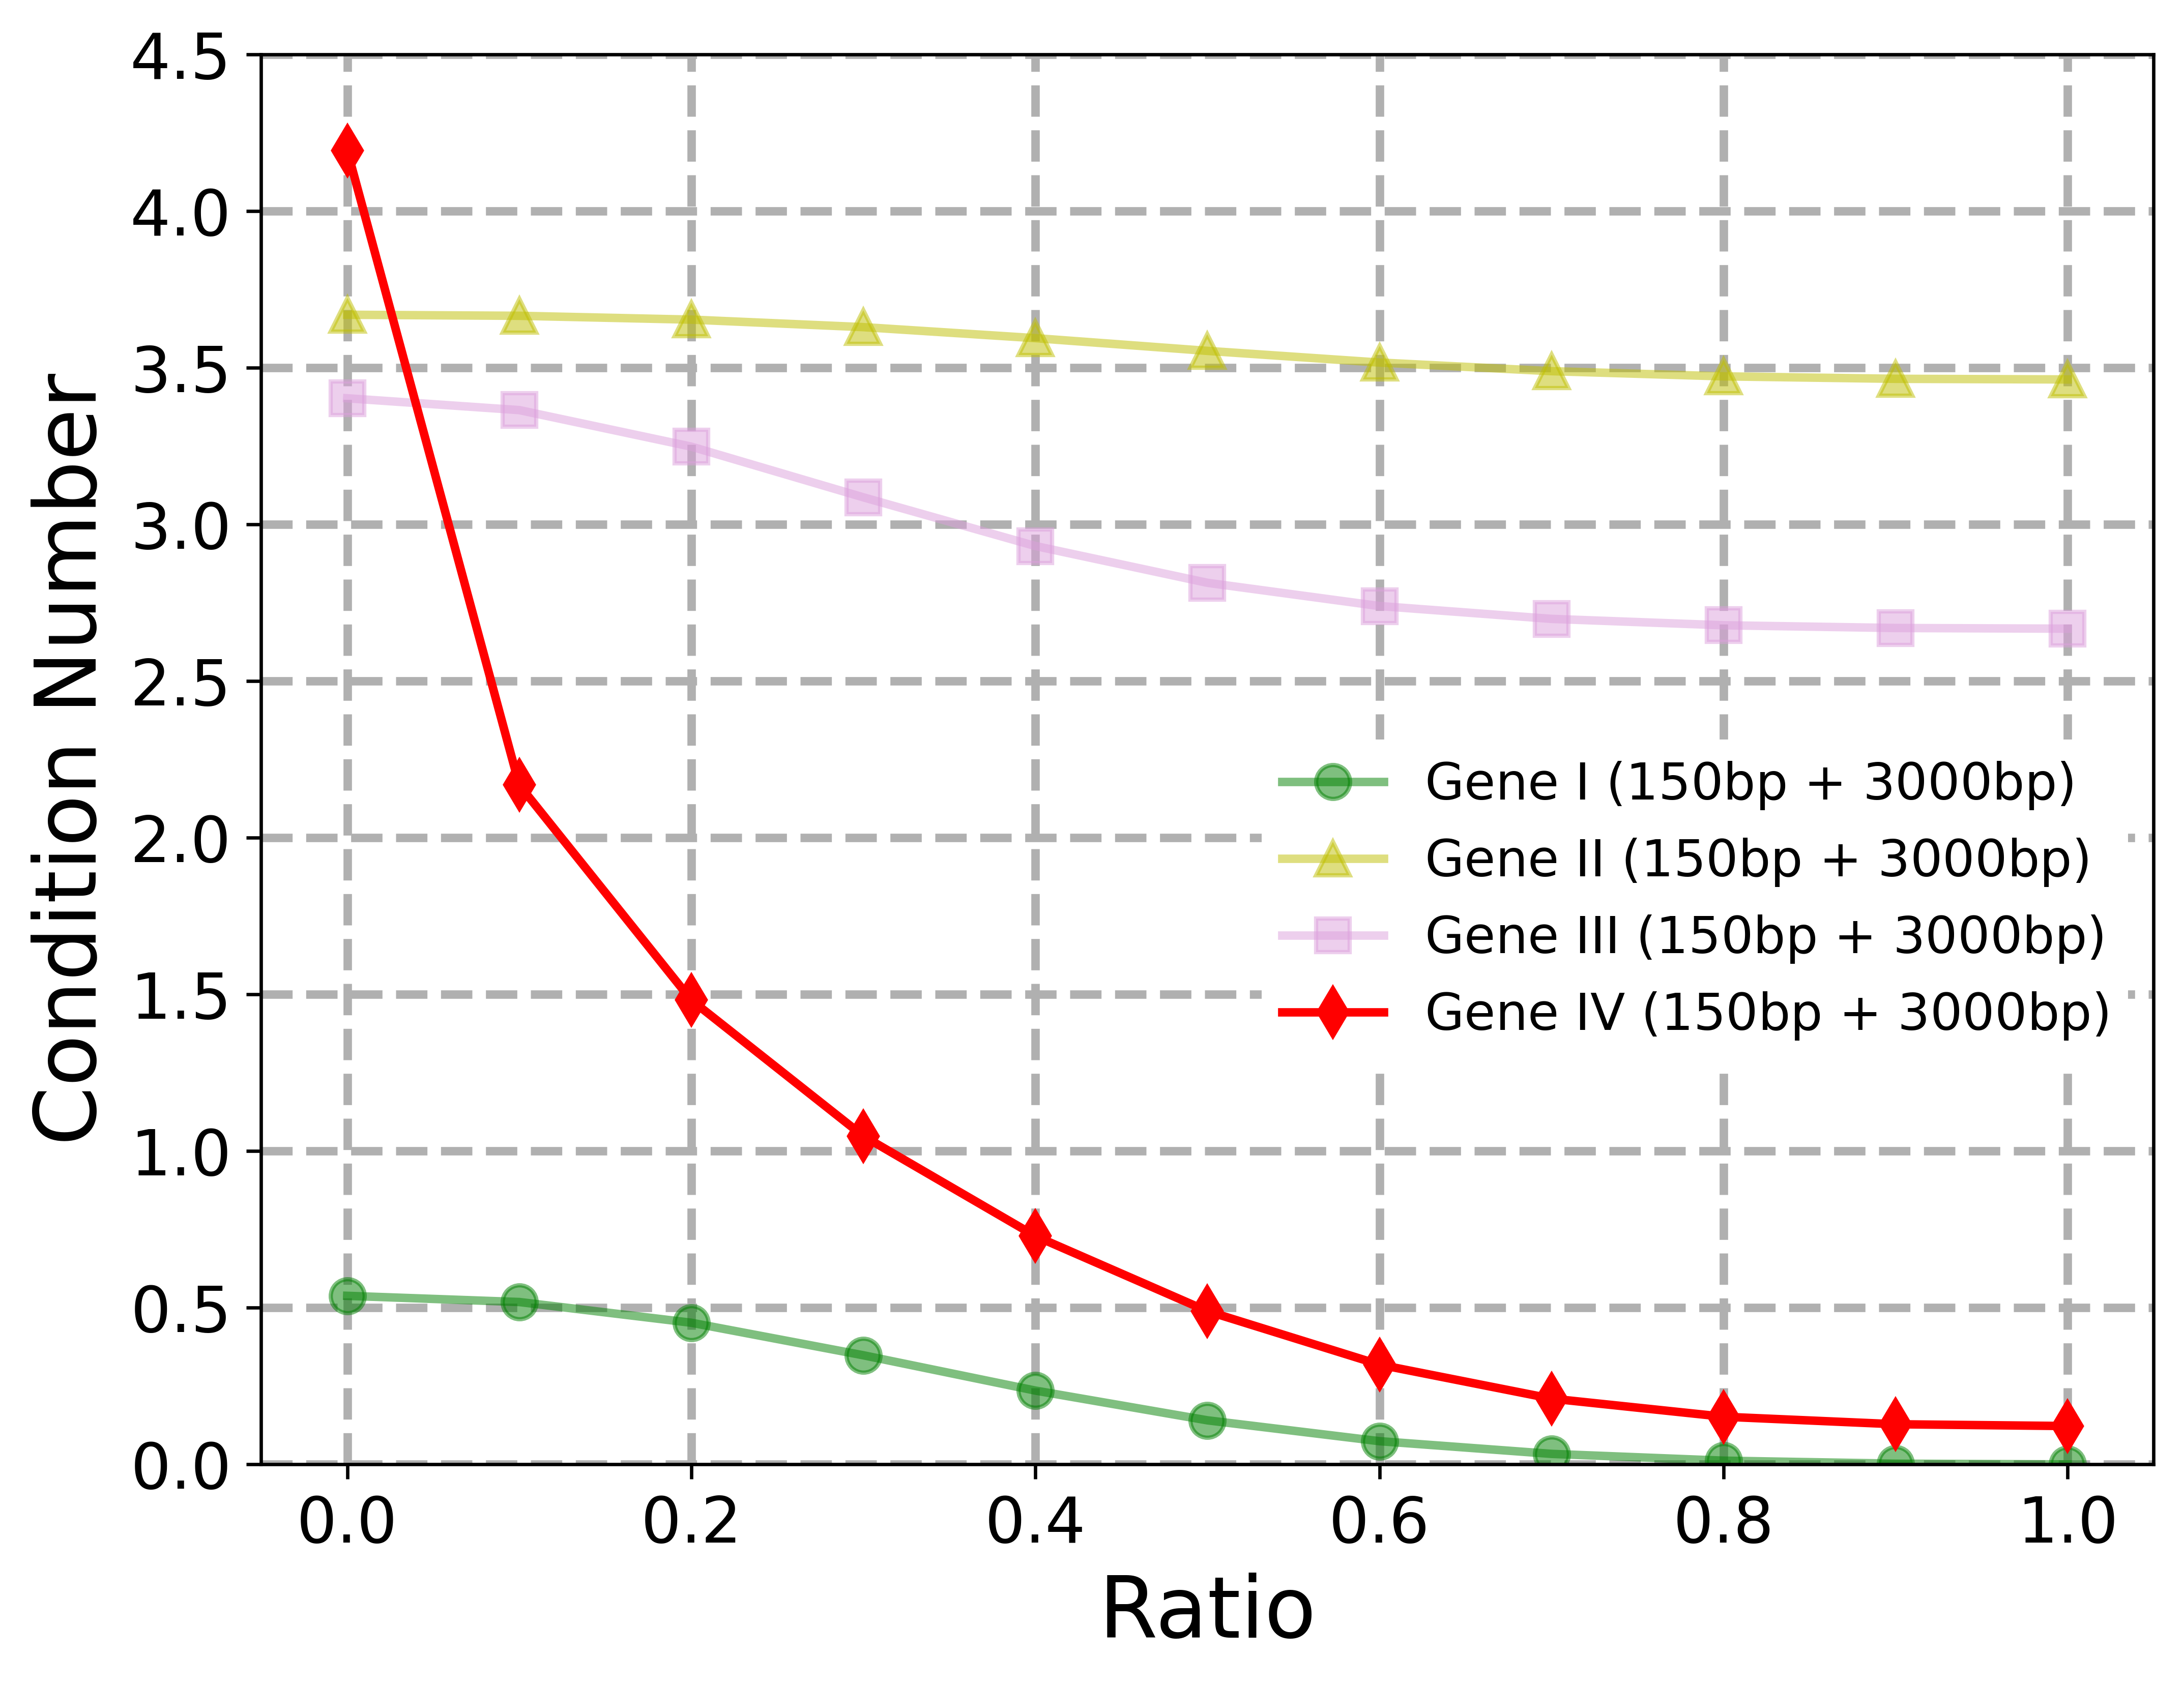

In [12]:
# Initialize condition number list
x = np.linspace(0, 1, 11)

# Create figure
plt.figure(figsize=(8, 6), dpi = 600)

# Plot line graphs
# plt.plot(x, cond_mix_loaded[0], 'ro-', label='2000 mix 3000', linewidth=2, markersize=8)  # Red line with circle markers
plt.plot(x, condition_numbers_1, 'go-', label=r'Gene $\mathrm{I}$ (150bp + 3000bp)', linewidth=2, markersize=8, alpha=0.5)  # Green line with circle markers
plt.plot(x, condition_numbers_2, 'y^-', label=r'Gene $\mathrm{II}$ (150bp + 3000bp)', linewidth=2, markersize=8, alpha=0.5)  # Yellow line with triangle markers
plt.plot(x, condition_numbers_3, color='#DDA0DD', marker='s', linestyle='-', label=r'Gene $\mathrm{III}$ (150bp + 3000bp)', linewidth=2, markersize=8, alpha=0.5)  # Light purple line with square markers
plt.plot(x, condition_numbers_4, 'r-d', label=r'Gene $\mathrm{IV}$ (150bp + 3000bp)', linewidth=2, markersize=8)  # Red line with diamond markers

# Add titles and labels
# plt.title('Line Plot with Different Markers and Colors')
plt.xlabel('Ratio', fontsize=20)
plt.ylabel('Condition Number', fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Add legend
plt.legend(loc='center right',  bbox_to_anchor=(1.0, 0.4), frameon=True, fontsize=12, facecolor='white', framealpha=1, edgecolor='none')

# Add grid lines
plt.grid(True, linestyle='--',  alpha=1.0, linewidth=2.0)

plt.ylim(0, 4.5)

# Show figure
plt.show()

Draw Error Plot

In [13]:
with open('Figure_4_data/error_data.json', 'r') as f:
    loaded_data = json.load(f)

# Use loaded data
error_low = loaded_data['error_low']
error_high = loaded_data['error_high']
error_down = loaded_data['error_down']
error_mix_1 = loaded_data['error_mix_1']
error_mix_2 = loaded_data['error_mix_2']
error_mix_3 = loaded_data['error_mix_3']

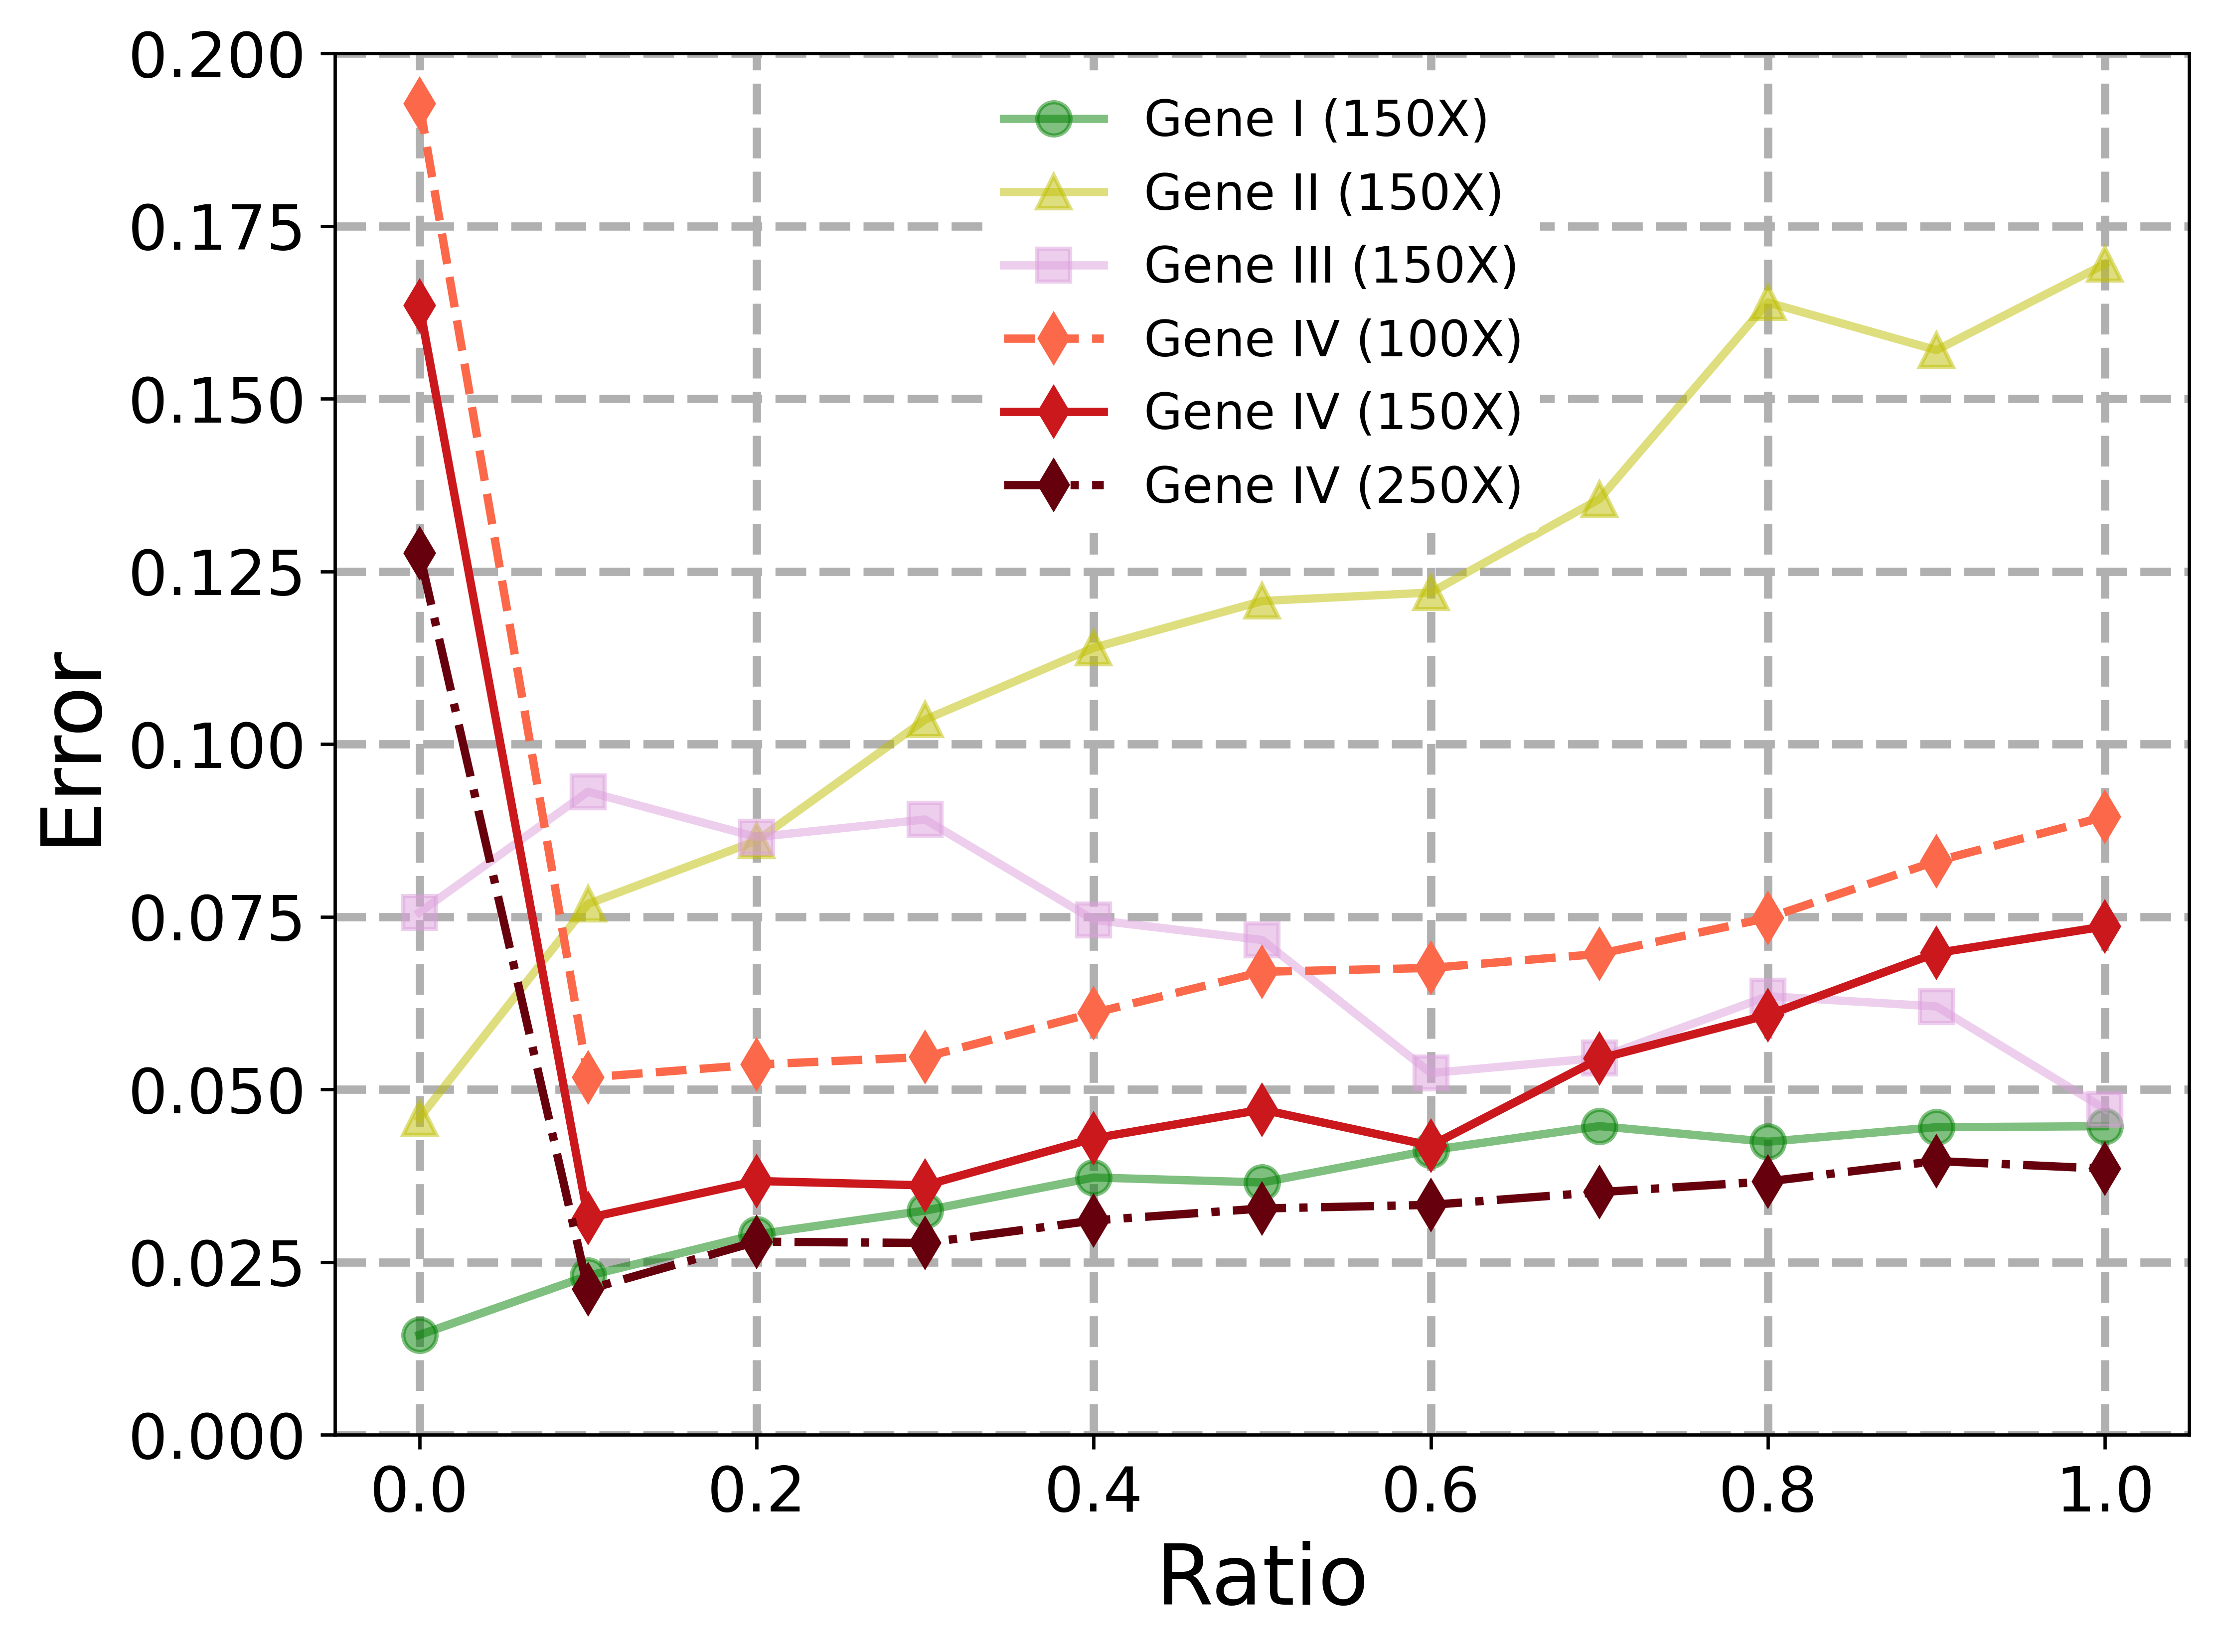

In [14]:
# Example data
x = np.linspace(0, 1, 11)

# Create figure
plt.figure(figsize=(8, 6), dpi = 600)

# Plot line graphs
plt.plot(x, error_low, color='green', marker='o', linestyle='-', label=r'Gene $\mathrm{I}$ (150X)', linewidth=2, markersize=8, alpha=0.5) 
plt.plot(x, error_high, 'y^-', label=r'Gene $\mathrm{II}$ (150X)', linewidth=2, markersize=8, alpha=0.5)  # Yellow line with triangle markers
plt.plot(x, error_down, color='#DDA0DD', marker='s', linestyle='-', label=r'Gene $\mathrm{III}$ (150X)', linewidth=2, markersize=8, alpha=0.5)  # Light purple line with square markers

# Create gradient colors
colors = cm.Reds(np.linspace(0.5, 1, 3))

plt.plot(x, error_mix_1, color=colors[0], marker='d', linestyle='--', label=r'Gene $\mathrm{IV}$ (100X)', linewidth=2, markersize=8)  # Gradient blue dashed line with star markers
plt.plot(x, error_mix_2, color=colors[1], marker='d', linestyle='-', label=r'Gene $\mathrm{IV}$ (150X)', linewidth=2, markersize=8)  # Gradient blue line with star markers
plt.plot(x, error_mix_3, color=colors[2], marker='d', linestyle='-.', label=r'Gene $\mathrm{IV}$ (250X)', linewidth=2, markersize=8)  # Gradient blue dash-dot line with star markers

# Add titles and labels
# plt.title('Line Plot with Different Markers and Colors')
plt.xlabel('Ratio', fontsize=20)
plt.ylabel('Error', fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Add legend
plt.legend(frameon=True, fontsize=12, facecolor='white', framealpha=1, edgecolor='none')

# Add grid lines
plt.grid(True, linestyle='--',  alpha=1.0, linewidth=2.0)

plt.ylim(0, 0.2)

# Show figure
plt.show()

Draw Statistical Data Plot

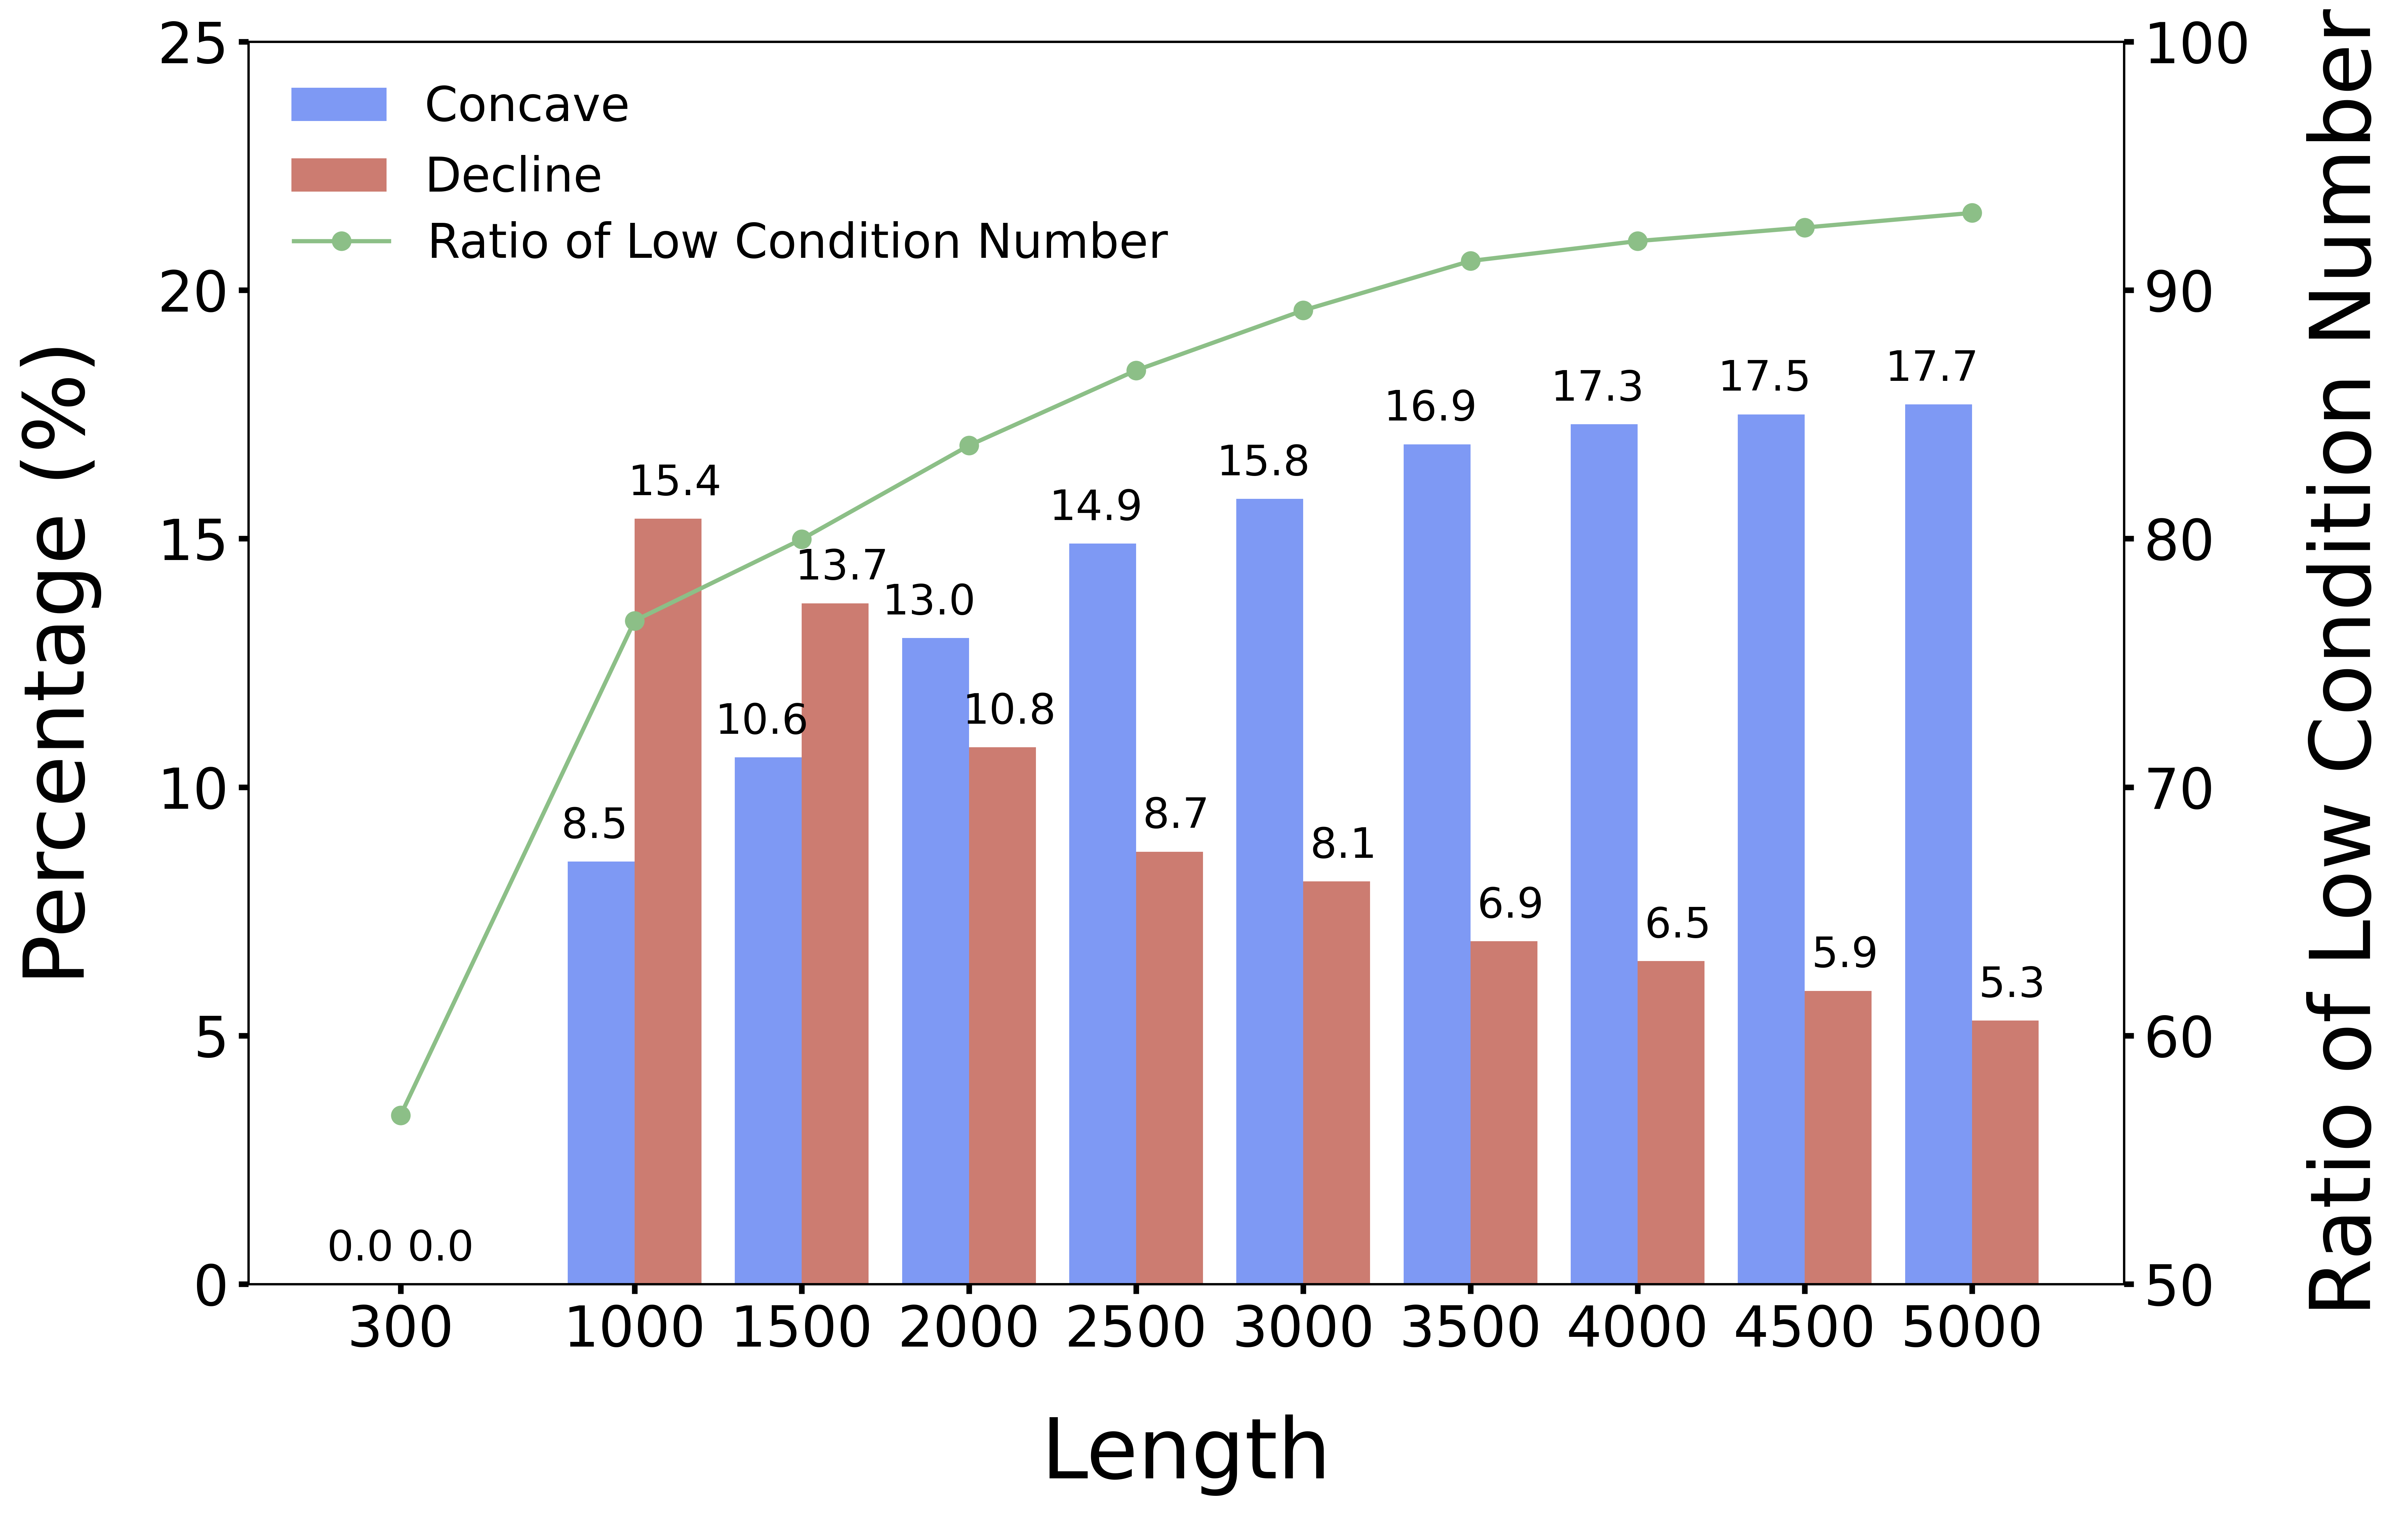

In [15]:
# Concave type
percentages1 = [0, 8.5, 10.6, 13.0, 14.9, 15.8, 16.9, 17.3, 17.5, 17.7]

# Decline type
percentages2 = [0, 15.4, 13.7, 10.8, 8.7, 8.1, 6.9, 6.5, 5.9, 5.3]

# Statistical chart data
percentages3 = [56.790255369163376, 76.6962282295117, 79.97649321508709, 83.74826370338711, 86.77209103536703, 89.1868789400577, 91.17427075542258, 91.97563842290843, 92.5205684367988, 93.10823805962175]
line_data = percentages3

# Generate evenly spaced x-axis labels from 1000 to 5000
x_labels = np.linspace(1000, 5000, len(percentages1) - 1)
x_labels = np.insert(x_labels, 0, 300)

# Create color for first group data
color1 = '#7E99F4'

# Create color for second group data
color2 = '#CC7C71'

# Line chart color (slightly brighter green)
line_color = '#8CBF87'

# Create figure
fig, ax1 = plt.subplots(figsize=(12, 8), dpi = 600)

# Bar chart width
bar_width = 200

# Draw bar chart for first group data
bars1 = ax1.bar(x_labels - bar_width/2, percentages1, color=color1, width=bar_width, label='Concave')

# Draw bar chart for second group data
bars2 = ax1.bar(x_labels + bar_width/2, percentages2, color=color2, width=bar_width, label='Decline')

# Add titles and labels
ax1.set_ylabel('Percentage (%)', fontsize=30, labelpad=20)
ax1.set_xlabel('Length', fontsize=30, labelpad=20)

# Set x-axis ticks and labels
ax1.set_xticks(x_labels)
ax1.set_xticklabels([f'{int(label)}' for label in x_labels], fontsize=15)
# Set y-axis tick font size
ax1.tick_params(axis='x', width=2, colors='black', labelsize=20, labelcolor='black')

# Set y-axis range
ax1.set_ylim(0, 25)

# Set y-axis tick font size
ax1.tick_params(axis='y', width=2, colors='black', labelsize=20, labelcolor='black')

# Add percentage values on each bar chart (first group data)
for bar, perc in zip(bars1, percentages1):
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2 - 20, yval + 0.3, f'{perc:.1f}', ha='center', va='bottom', fontsize=15, color='black')

# Add percentage values on each bar chart (second group data)
for bar, perc in zip(bars2, percentages2):
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2 + 20, yval + 0.3, f'{perc:.1f}', ha='center', va='bottom', fontsize=15, color='black')

# Add legend and remove border
legend1 = ax1.legend(loc='upper left', frameon=False, fontsize=17)

# Create second y-axis
ax2 = ax1.twinx()

# Set second y-axis range
ax2.set_ylim(50, 100)

# Set second y-axis tick font size
ax2.tick_params(axis='y', width=2, colors='black', labelsize=20, labelcolor='black')

# Draw line chart
ax2.plot(x_labels, line_data, color=line_color, marker='o', linestyle='-', label='Ratio of Low Condition Number')

# Add second y-axis label
ax2.set_ylabel('Ratio of Low Condition Number', fontsize=30, labelpad=20)

# Add line chart legend and place below bar chart
legend2 = ax2.legend(loc='upper right', bbox_to_anchor=(0.513, 0.89), frameon=False, fontsize=17)

# Show figure
plt.show()